In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import optuna
import optuna.visualization
from xgboost import XGBRegressor
from sklearn.base import clone

def read_df(path):
    return pd.read_csv(path)

def delete_columns(df, columns):
    return df.drop(columns=[col for col in columns if col in df.columns])

def prepare_dataframe(df, datetime_col="Datetime", freq="30min"):
    """Ensure datetime formatting and regular time frequency in the DataFrame."""
    df = df.copy()
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df = df.sort_values(datetime_col)
    df = df.set_index(datetime_col)

    # Check for uniform frequency
    inferred_freq = pd.infer_freq(df.index)
    if inferred_freq != freq:
        raise ValueError(f"Inconsistent time step: expected {freq}, for {inferred_freq}")
    return df

def split_train_cal_test(df, cal_year=2021, test_year=2022):
    """
    Split the DataFrame into train, calibration, and test sets based on year boundaries.
    """
    df_train = df[df.index.year < cal_year]
    df_cal = df[df.index.year == cal_year]
    df_test = df[df.index.year == test_year]
    return df_train, df_cal, df_test

def create_windows_dataset(df, window_size = 48, target_col="Consommation"):
    """Create sliding window input-output pairs from a time series Datetime"""
    values = df[target_col].values
    X, y = [], []

    for i in range(window_size, len(values)):
        X.append(values[i - window_size:i])
        y.append(values[i])

    X = np.array(X)
    y = np.array(y)
    return X, y

#### Training Modul ####
class Train:
    """Wrapper class for XGBRegressor with optional conformal calibration."""

    def __init__(self, method='enbpi', cv = 'prefit', model_kwargs=None, verbose=True):
        self.verbose = verbose
        self.model_kwargs = model_kwargs or {}
        self.base_model = XGBRegressor(**self.model_kwargs)
        self.model = clone(self.base_model)
        self.is_fitted = False

    def fit(self, X, y):
        """Train the model on input X and target y."""
        self.model.fit(X, y)
        self.is_fitted = True
        
    def predict(self, X):
        """Predict target values from input X"""
        if not self.is_fitted:
            raise RuntimeError("Model must be fitted before prediction.")

        preds = self.model.predict(X)
        return preds
        
    def infer_sequence(self, start_sequence, horizon=48):
        """Perform step-by-step autoregressive inference over a sequence horizon"""
        if not self.is_fitted:
            raise RuntimeError("Model must be fitted before inference.")

        window_size = len(start_sequence)
        if window_size != self.model.n_features_in_:
            raise ValueError(f"Expected input length {self.model.n_features_in_}, got {window_size}.")

        sequence = list(start_sequence.copy())
        preds = []

        for _ in range(horizon):
            input_window = np.array(sequence[-window_size:]).reshape(1, -1)
            pred = self.model.predict(input_window)
            preds.append(pred[0])
            sequence.append(pred[0])
        return np.array(preds)

class Calibrator:
    def __init__(self, model, error_type="raw"):
        """
        Initializes the calibrator.
        """
        self.model = model
        self.error_type = error_type
        self.q_inf = None
        self.q_sup = None

    def fit(self, X_cal, y_cal, alpha=0.05):
        """
        Calibrates the interval bounds on the calibration set errors.
        """
        y_pred = self.model.predict(X_cal)
        errors = y_cal - y_pred

        if self.error_type == "absolute":
            errors = np.abs(errors)

        self.q_inf = np.quantile(errors, alpha / 2)
        self.q_sup = np.quantile(errors, 1 - alpha / 2)

    def predict(self, X, alpha=0.05):
        """
        Makes a prediction and returns interval bounds:
        y_pred, (lower_bound, u
        """
        y_pred = self.model.predict(X)
        lower = y_pred + self.q_inf
        upper = y_pred + self.q_sup

        intervals = np.stack([lower, upper], axis=1)
        return y_pred, intervals


#### Methods #####
def pinball_loss(y_true, y_pred, quantile):
    delta = y_true - y_pred
    return np.mean(np.maximum(quantile * delta, (quantile - 1) * delta))


def evaluate_predictions(y_true, y_pred, lower, upper, quantile=0.95):
    """
    Evaluates model performance with confidence intervals.

    Parameters :
    - y_true: actual values
    - y_pred: central predictions
    - lower: lower limits of intervals
    - upper: upper limits of intervals
    - quantile : ex: 0.95 for a 95% CI

    Returns :
    - dictionary with RMSE, MAE, R², coverage, width, pinball lower & upper, overflow_rate
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    lower = np.array(lower)
    upper = np.array(upper)

    # Coverage
    coverage = np.mean((y_true >= lower) & (y_true <= upper))

    # Average interval width
    interval_width = np.mean(upper - lower)

    # Pinball Loss
    pll = pinball_loss(y_true, lower, quantile=quantile / 2)
    plu = pinball_loss(y_true, upper, quantile=1 - quantile / 2)

    return {
        "rmse": root_mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred),
        "coverage": coverage,
        "interval_width": interval_width,
        "pinball_loss_lower": pll,
        "pinball_loss_upper": plu,
        "overflow_rate": np.mean(y_true > upper)
    }

def plot_inference_for_date(model, df, date_str, window_size=48, horizon=48, target_col="Consommation", alpha=0.05):
    """Plot prediction, confidence interval, and true values for a given date using inference."""
    date_start = pd.to_datetime(date_str + " 00:00")
    idx_start = df.index.get_loc(date_start)

    # Vérifie qu'on a assez de données en amont
    if idx_start < window_size:
        raise ValueError("Not enough data before the selected date to build the input sequence.")

    # Séquence d'entrée juste avant le jour ciblé
    input_sequence = df.iloc[idx_start - window_size:idx_start][target_col].values

    # Vraies valeurs pour la journée prédite
    y_true = df.iloc[idx_start:idx_start + horizon][target_col].values

    # Horaires 30min : 00:00, 00:30, ..., 23:30
    hours = [f"{int(h//2):02d}:{'30' if h%2 else '00'}" for h in range(horizon)]

    # Prédiction
    if model.calibrated:
        y_pred, y_lower, y_upper = model.infer_sequence(input_sequence, horizon=horizon, return_interval=True, alpha=alpha)
        y_lower = np.ravel(y_lower)
        y_upper = np.ravel(y_upper)
    else:
        y_pred = model.infer_sequence(input_sequence, horizon=horizon, return_interval=False)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(hours, y_true, label="True consumption", linewidth=2)
    plt.plot(hours, y_pred, label="Prediction", linestyle="--", linewidth=2)

    if model.calibrated:
        plt.fill_between(hours, y_lower, y_upper, color="gray", alpha=0.3, label="Confidence Interval")

    plt.title(f"Prediction vs True Consumption for {date_str}")
    plt.xlabel("Time of day")
    plt.ylabel("MW")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_multiple_random_days(model, df_test, year=2022, n_days=5, seed=None):
    """Trace n journées aléatoires de test avec prédiction + intervalle de confiance."""
    if seed is not None:
        random.seed(seed)
    
    # Liste de tous les jours disponibles en 2022 dans df_test
    all_dates = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31", freq="D")
    available_dates = [d.strftime("%Y-%m-%d") for d in all_dates if d in df_test.index]

    sampled_dates = random.sample(available_dates, k=n_days)
    
    for i, date_str in enumerate(sampled_dates):
        print(f"\nJour {i+1} : {date_str}")
        plot_inference_for_date(model, df_test, date_str, window_size=336, horizon=48)

In [2]:
# === 1. Chargement des données nettoyées ===
df = read_df("cleaned_data/cleaned_without_nan_non_aggregate_data_15_22.csv")

# === 2. Suppression des colonnes inutiles ===
df = delete_columns(df, ['Prévision J-1', 'Prévision J'])

# === 3. Préparation datetime + fréquence régulière ===
df = prepare_dataframe(df, datetime_col="Datetime", freq="30min")

# === 4. Split en train / calibration / test ===
df_train, df_cal, df_test = split_train_cal_test(df, cal_year=2021, test_year=2022)

# === 5. Fenêtrage glissant (ici 336 = 1 semaine) ===
X_train, y_train = create_windows_dataset(df_train, window_size=336)
X_cal, y_cal = create_windows_dataset(df_cal, window_size=336)
X_test, y_test = create_windows_dataset(df_test, window_size=336)

# === 6. Entraînement du modèle ===
model = Train(verbose=True)
model.fit(X_train, y_train)

# === 7. Calibration manuelle de l’intervalle de confiance ===
calibrator = Calibrator(model.model, error_type="raw")
calibrator.fit(X_cal, y_cal, alpha=0.05)

# === 8. Prédiction avec intervalles sur le jeu de test ===
y_pred, intervals = calibrator.predict(X_test, alpha=0.05)
lower = intervals[:, 0]
upper = intervals[:, 1]

# === 9. Évaluation des performances ===
metrics = evaluate_predictions(y_test, y_pred, lower, upper, quantile=0.95)
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

rmse: 462.1700
mae: 353.3873
r2: 0.9983
coverage: 0.9556
interval_width: 1910.0278
pinball_loss_lower: 463.7439
pinball_loss_upper: 455.3244
overflow_rate: 0.0225


## Analyse des performances du modèle calibré

Après recalibrage sur l’année 2021 avec la méthode empirique (`raw errors`), le modèle XGBoost a été évalué sur les données de test 2022. Les résultats sont très satisfaisants.

* **RMSE = 462.17** et **MAE = 353.39**, ce qui est faible comparé aux valeurs moyennes de consommation (\~50 000 MWh). L’erreur absolue moyenne reste bien contenue.
* **R² = 0.9983** confirme une qualité de prédiction très élevée, le modèle colle quasi parfaitement aux données réelles.
* L’**intervalle de confiance** à 95% est calibré de manière pertinente :

  * **Coverage = 95.56%**, ce qui respecte la cible statistique visée.
  * **Largeur moyenne de l’intervalle** : 1910 MWh. C’est une marge raisonnable compte tenu des dynamiques de consommation.
* **Pinball Loss** (inf. : 463.74 / sup. : 455.32) montre un bon équilibre entre les bornes inférieures et supérieures.
* **Overflow rate = 2.25%** : dans 2.25% des cas, la consommation réelle dépasse la borne supérieure prédite. C’est très acceptable et rassurant dans une optique de surdimensionnement conservateur.

**En résumé**, le calibrage via quantiles bruts (non symétrisés) est bien plus robuste que l’approche par valeur absolue. Il permet une capture plus fine des asymétries d’erreurs, et produit des intervalles adaptés aux cas réels, tout en maîtrisant les débordements critiques. Le modèle peut donc être utilisé en production avec un bon niveau de confiance.

## Correction de l’accumulation d’erreur en prédiction auto-régressive

L'utilisation d'une approche auto-régressive pour les séries temporelles, où chaque prédiction devient progressivement une partie intégrante des entrées suivantes, entraîne souvent une accumulation d'erreurs. En effet, même une faible erreur à un instant donné peut s'amplifier à mesure que les prédictions successives s’enchaînent.

Pour traiter ce phénomène, une méthodologie structurée en plusieurs étapes est nécessaire. L'objectif premier est d'étudier précisément comment l'erreur évolue, afin d'envisager des solutions adaptées :

### 1. Analyse approfondie de l'erreur

Dans un premier temps, il est essentiel d'analyser en détail le comportement de l'erreur sur un jeu de calibration suffisamment représentatif. Concrètement, on effectue les étapes suivantes :

* Sélectionner un grand nombre de séquences auto-régressives à partir du jeu de calibration (année 2021), afin d'avoir une représentation robuste des erreurs.
* Générer les prédictions auto-régressives à l'aide du modèle déjà entraîné, sur un horizon d'une journée (48 valeurs).
* Calculer systématiquement l'erreur à chaque pas de prédiction :

$$
\text{Erreur}(t) = y_{\text{réel}}(t) - y_{\text{prédit}}(t)
$$

### 2. Caractérisation du comportement de l'erreur

Une fois ces erreurs obtenues, l’étape suivante est d'identifier clairement le type de comportement observé à travers des visualisations graphiques et des analyses statistiques :

* Tracer les courbes des erreurs pour chaque séquence afin d’observer visuellement les motifs récurrents (linéaires, exponentiels, saisonniers, etc.).
* Ajuster une droite affine pour chaque séquence d’erreurs afin de déterminer la présence éventuelle d’une dérive linéaire :

$$
\text{Erreur}(t) \approx a \cdot t + b
$$

où $a$ est la pente et $b$ l’interception.

* En cas de dérive non-linéaire évidente, envisager des ajustements polynomiaux simples (quadratiques, cubiques) :

$$
\text{Erreur}(t) \approx a \cdot t^2 + b \cdot t + c
$$

* Si l’erreur présente des motifs récurrents complexes, tester rapidement une modélisation via un modèle léger (par exemple un autre modèle XGBoost simplifié ou un modèle linéaire multiple sur quelques pas de temps précédents).

### 3. Proposition et évaluation d'une correction adaptée

Enfin, selon les résultats de l'analyse précédente, il sera possible de choisir la stratégie corrective la plus appropriée :

* **Correction linéaire simple :**

$$
y_{\text{corrigé}}(t) = y_{\text{prédit}}(t) + a \cdot t + b
$$

* **Correction polynomiale :**

$$
y_{\text{corrigé}}(t) = y_{\text{prédit}}(t) + a \cdot t^2 + b \cdot t + c
$$

* **Correction par modèle secondaire (modèle prédictif d’erreur) :**

$$
y_{\text{corrigé}}(t) = y_{\text{prédit}}(t) + e_{\text{modèle secondaire}}(t)
$$


### Observation locales

In [3]:
def analyze_autoregressive_error(model, X_cal, y_cal, sample_index=None, horizon=48):
    """
    Analyse le comportement de l'erreur en auto-régression sur un échantillon aléatoire des données de calibration.
    """
    if sample_index is None:
        max_index = len(X_cal) - horizon
        sample_index = random.randint(0, max_index)

    # Extraire la séquence initiale pour l'inférence
    x_start = X_cal[sample_index]
    
    # Récupérer la vraie courbe
    true_values = y_cal[sample_index:sample_index + horizon]
    
    # Lancer l'inférence auto-régressive
    pred_values = model.infer_sequence(x_start, horizon=horizon)

    # Calcul de l'erreur
    error = true_values[:len(pred_values)] - pred_values

    # Courbe d'erreur + tendance linéaire
    t = np.arange(len(error))
    coeffs = np.polyfit(t, error, deg=1)
    trend = coeffs[0] * t + coeffs[1]

    # Affichage
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(true_values, label="True")
    plt.plot(pred_values, label="Predicted")
    plt.title("Prediction vs Real (auto-regressive)")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(error, label="Error (Real - Pred)")
    plt.plot(trend, label="Linear Trend", linestyle="--")
    plt.title("Error over horizon")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        "mean_error": np.mean(error),
        "std_error": np.std(error),
        "linear_trend_slope": coeffs[0],
        "linear_trend_intercept": coeffs[1],
        "rmse": np.sqrt(np.mean(error**2))
    }

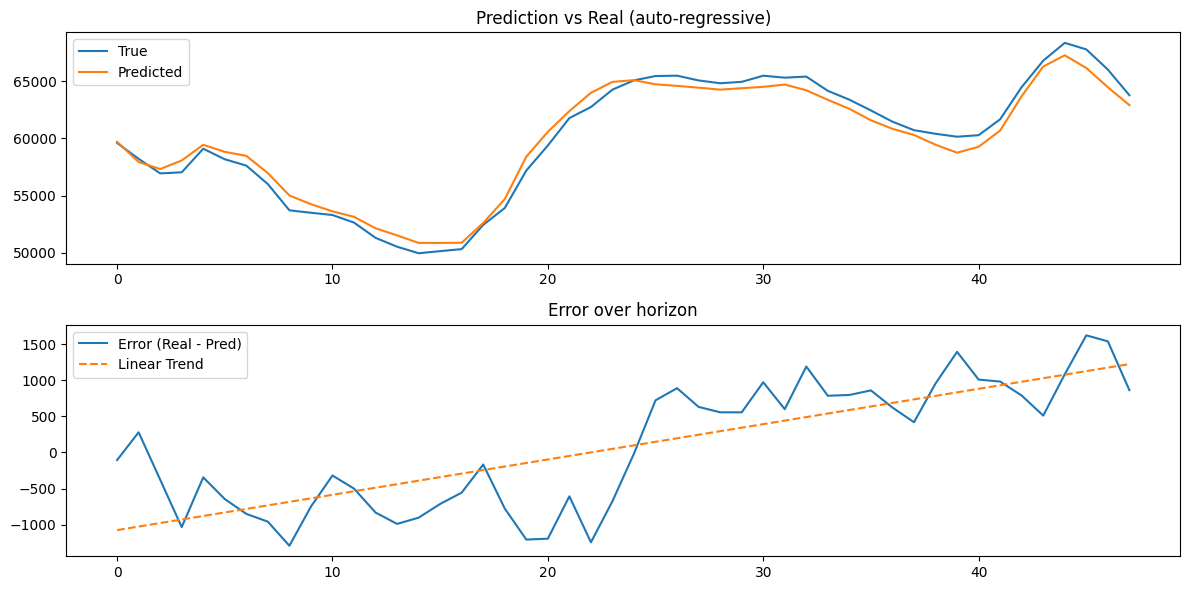

{'mean_error': 74.70076497395833,
 'std_error': 857.3438258694804,
 'linear_trend_slope': 48.96550334312583,
 'linear_trend_intercept': -1075.9885635894984,
 'rmse': 860.5920288058752}

In [10]:
analyze_autoregressive_error(model, X_cal, y_cal, sample_index=None, horizon=48)

### Conclusion intermédiaire après analyse visuelle des erreurs auto-régressives

L'analyse visuelle initiale des prédictions auto-régressives (réalisées avec la fonction `analyze_autoregressive_error`) permet déjà d'identifier plusieurs phénomènes intéressants :

#### 1. **Qualité globale des prédictions (tendance préservée)**

* Le modèle **préserve très bien la tendance générale** des données réelles.
  **Concrètement :**

  * Lorsque la série réelle augmente, la prédiction augmente également.
  * Lorsque la série réelle diminue, la prédiction diminue de manière correspondante.
    Cela signifie que le modèle capture efficacement la structure générale et les variations de la série temporelle, probablement grâce à un R² élevé en entraînement.

#### 2. **Caractéristiques de l'accumulation d'erreur**

* L'erreur n'est pas strictement croissante ni décroissante, mais présente plutôt un **comportement fluctuant**, ce qui indique un effet de "zigzag".

* L'accumulation d'erreur est **non monotone** :

  * Au début (premières prédictions), les valeurs prédites restent souvent très proches des valeurs réelles.
  * Vers le milieu de l’horizon (entre 5 et 25 typiquement), l’erreur commence à croître plus clairement, avec un "gap" ou une divergence plus visible.
  * Vers la fin de l’horizon (approche des 48 pas), il arrive que les courbes "recollent", suggérant une certaine forme d’auto-correction intrinsèque, sans que cette correction soit systématique.

* L’erreur observée est souvent un décalage constant vertical (vers le haut ou vers le bas selon les séquences), mais ce décalage n’est pas constant dans le temps. Parfois, il s’inverse :

  * Certaines séquences montrent les prédictions systématiquement sous les valeurs réelles, d’autres systématiquement au-dessus, et d'autres alternent.

#### 3. **Forme et variabilité de l'erreur (linéaire avec forte variance)**

* Visuellement, l’erreur présente une **tendance linéaire générale** (confirmée par la droite ajustée), ce qui indique une dérive légère mais systématique au fil du temps.
* **Cependant**, cette tendance linéaire est accompagnée d'une **très forte variabilité** locale. L’erreur présente de nombreux pics très prononcés (amplitude élevée), et des inversions fréquentes positives/négatives.
* La variance est suffisamment forte pour que, même avec une tendance linéaire visible, on ne puisse pas conclure à une simple dérive linéaire isolée.

---

#### Interprétations et hypothèses préliminaires à tester dans l’analyse statistique suivante :

Cette première analyse visuelle suggère plusieurs points importants à tester :

* L’erreur moyenne sur plusieurs séquences est-elle statistiquement proche de zéro ?
  → Si oui, la principale correction serait centrée sur une **réduction de la variance**, plutôt que sur un biais constant.

* L’erreur linéaire (dérive constante vers le haut ou le bas) est-elle systématique (toujours positive ou toujours négative sur un grand nombre de cas), ou bien alterne-t-elle fréquemment ?
  → Si elle alterne beaucoup, une correction linéaire simple risque d'être insuffisante.

* La variabilité importante que tu observes visuellement implique probablement un impact des caractéristiques cycliques (jour/nuit, pic de consommation, périodes spécifiques) que le modèle peine à capturer totalement en autorégression.

---

#### Stratégies correctives envisageables au vu de cette première analyse :

À ce stade visuel, on pourrait déjà anticiper trois pistes possibles selon les résultats statistiques à venir :

1. **Correction linéaire simple** : utile uniquement si l’analyse statistique confirme un biais systématique dans une direction constante sur une majorité de séquences.

2. **Correction locale (par période de la journée)** : si on constate que les erreurs systématiques correspondent à certaines périodes précises (ex : pics matinaux ou soirée).

3. **Correction par un modèle secondaire léger** (par exemple, prédiction de l’erreur par régression sur les erreurs précédentes) : utile si l’erreur présente une structure complexe mais partiellement prédictible.

### Etude globales

In [5]:
def build_autoregression_error_dataset(model, X_cal, y_cal, horizon=48, step=48):
    """
    Generate datasets for autoregressive error analysis.
    Returns:
        errors_df : DataFrame of raw prediction errors (each row is a sequence of errors)
        stats_df  : DataFrame of statistical summaries per autoregressive sequence
    """
    errors_list = []
    stats_list = []

    num_sequences = (len(X_cal) - horizon) // step

    for seq_idx in range(num_sequences):
        start_idx = seq_idx * step

        # Starting sequence for autoregressive inference
        x_start = X_cal[start_idx]

        # True target sequence
        true_values = y_cal[start_idx : start_idx + horizon]

        # Autoregressive predictions
        pred_values = model.infer_sequence(x_start, horizon=horizon)

        # Compute prediction error
        errors = true_values - pred_values

        # Calculate error statistics
        mean_error = np.mean(errors)
        std_error = np.std(errors)
        slope, intercept = np.polyfit(np.arange(horizon), errors, deg=1)
        rmse = np.sqrt(np.mean(errors**2))

        # Store raw errors
        errors_list.append(errors)

        # Store summarized statistics
        stats_list.append({
            "sequence_id": seq_idx,
            "mean_error": mean_error,
            "std_error": std_error,
            "trend_slope": slope,
            "trend_intercept": intercept,
            "rmse": rmse
        })

    # Create DataFrames
    errors_df = pd.DataFrame(errors_list, columns=[f"step_{i+1}" for i in range(horizon)])
    stats_df = pd.DataFrame(stats_list)

    return errors_df, stats_df

In [6]:
errors_df, stats_df = build_autoregression_error_dataset(model, X_cal, y_cal)

In [7]:
stats_df.head()

,sequence_id,mean_error,std_error,trend_slope,trend_intercept,rmse
0,0,-76.399089,1311.720247,-11.137490,185.331918,1313.943236
1,1,1637.930013,1379.638779,78.896001,-216.126010,2141.545678
2,2,-1979.485026,2925.266419,40.265707,-2925.729147,3532.073696
3,3,6004.451009,3082.167688,9.615987,5778.475324,6749.310304
4,4,-1644.207031,2577.476551,-151.238454,1909.896644,3057.254018


### Evolutions de chaque statistique 

In [11]:
def plot_autoregression_stats(stats_df):
    """
    Plot evolution curves for each statistical metric contained in the stats_df DataFrame.
    """
    required_cols = ['mean_error', 'std_error', 'trend_slope', 'trend_intercept', 'rmse']
    
    # Check presence of columns
    for col in required_cols:
        if col not in stats_df.columns:
            raise ValueError(f"Column '{col}' not found in stats_df.")
    
    # Plot each statistic individually
    for col in required_cols:
        plt.figure(figsize=(10, 4))
        plt.plot(stats_df['sequence_id'], stats_df[col], marker='o', linestyle='-', markersize=3, alpha=0.7)
        plt.title(f"Evolution of {col} across sequences")
        plt.xlabel("Sequence ID")
        plt.ylabel(col)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

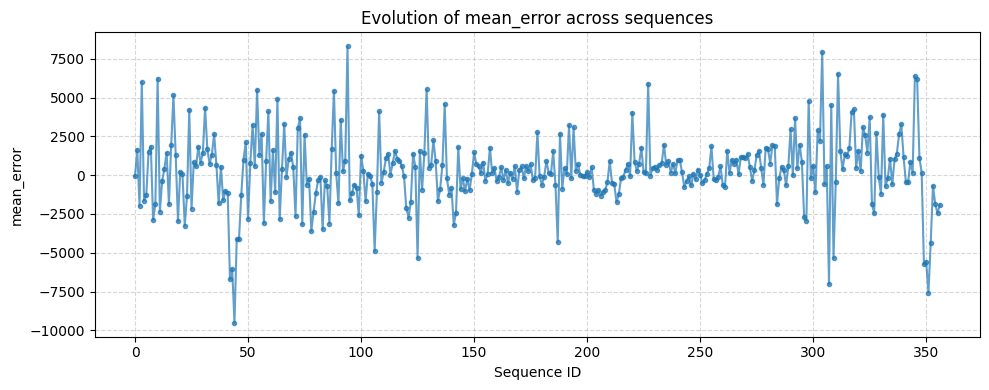

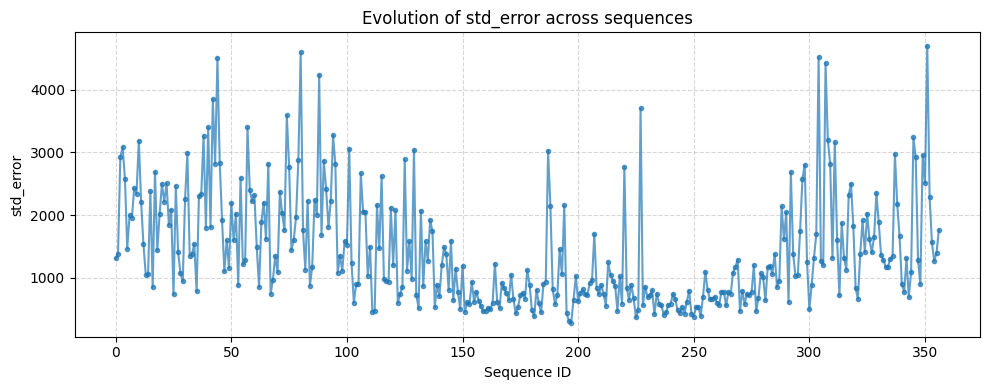

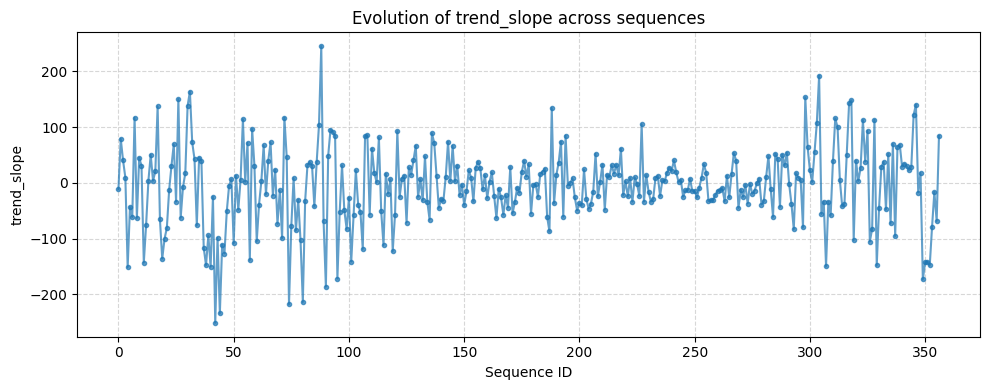

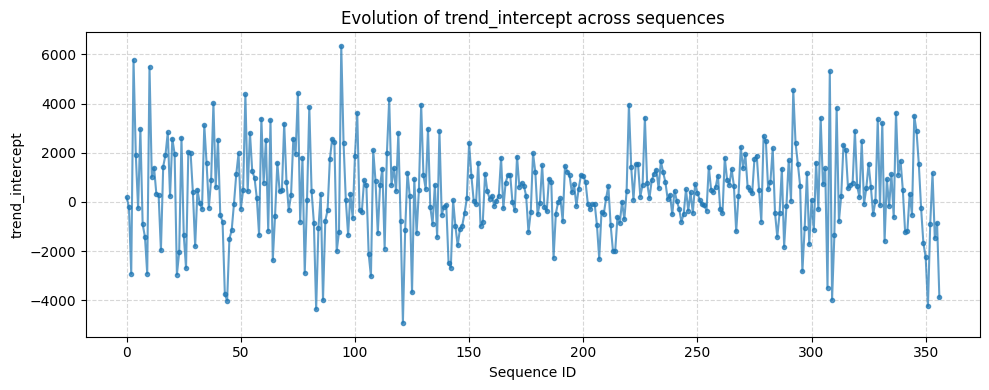

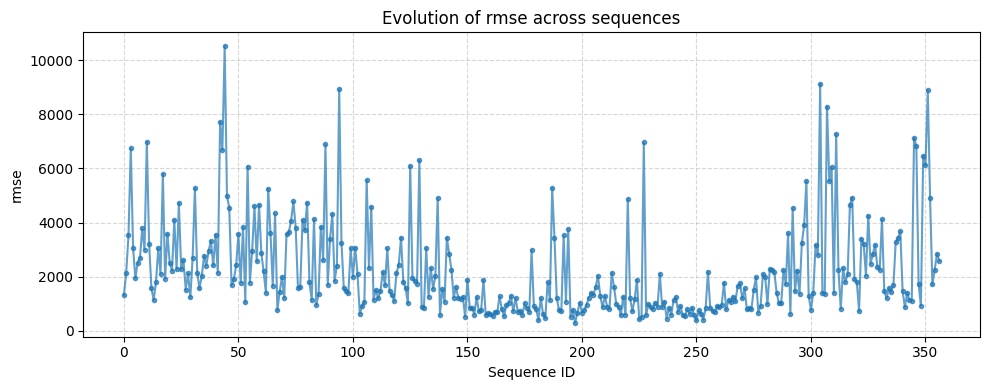

In [12]:
plot_autoregression_stats(stats_df)

### **Première lecture qualitative des métriques issues de l’autorégression**

* **`mean_error`** :
  La moyenne des erreurs oscille autour de zéro, ce qui indique qu’il n’y a pas de biais systématique net (le modèle ne surestime ni ne sous-estime globalement).
  Cependant, les variations très fortes (jusqu’à ±10 000) suggèrent que certaines séquences sont mal anticipées, probablement lors de changements brusques ou de pics.

* **`std_error`** :
  L’écart-type des erreurs montre une dispersion très variable, allant de \~500 à plus de 10 000.
  Cela révèle une **hétérogénéité forte dans la stabilité des prédictions** : certaines séquences sont très stables, d’autres très bruitées.

* **`trend_slope`** :
  La pente de la dérive de l’erreur est globalement centrée autour de zéro, mais avec des excursions fréquentes jusqu’à ±300.
  Cela montre que **la dérive linéaire de l’erreur existe, mais n’est pas systématiquement dans une même direction**.

* **`trend_intercept`** :
  L’ordonnée à l’origine varie également fortement (de −4000 à +6000), renforçant l’idée que certaines séquences présentent un décalage vertical marqué dès le départ.

* **`rmse`** :
  Les erreurs quadratiques totales varient énormément (\~500 à 10 000), ce qui **signale de gros écarts de performance selon les séquences**. Certaines sont prédites très précisément, d’autres sont franchement ratées.

Ces premiers résultats montrent que :

* Il **n’y a pas de biais global**, mais **de fortes fluctuations locales**.
* Le comportement du modèle varie fortement d'une séquence à l'autre.
* Une simple correction linéaire pourrait fonctionner dans certains cas, mais pas pour tous — il faudra peut-être **adapter dynamiquement** la correction (ou au moins la moduler selon des profils de séquences).

### Rtude générale des stats des erreurs

In [14]:
def summarize_stats_dataframe(df, exclude_columns=['sequence_id']):
    """
    Compute descriptive statistics for each numerical column in the input DataFrame,
    excluding identifier columns.
    """
    numeric_cols = [col for col in df.columns if col not in exclude_columns and pd.api.types.is_numeric_dtype(df[col])]
    
    summary = []

    for col in numeric_cols:
        series = df[col].dropna()
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        summary.append({
            "metric": col,
            "mean": series.mean(),
            "median": series.median(),
            "std": series.std(),
            "min": series.min(),
            "max": series.max(),
            "Q1": q1,
            "Q3": q3,
            "IQR": q3 - q1
        })

    summary_df = pd.DataFrame(summary).set_index("metric")
    return summary_df

In [16]:
summary_df = summarize_stats_dataframe(stats_df)
summary_df.head()

,mean,median,std,min,max,Q1,Q3,IQR
metric,,,,,,,,
mean_error,278.976146,251.809245,2261.157402,-9517.218506,8311.834880,-632.004150,1263.765869,1895.770020
std_error,1416.681460,1157.792014,886.181171,283.407431,4694.265675,743.344936,1956.582606,1213.237671
trend_slope,-5.243187,0.839048,68.867947,-251.181990,245.216553,-38.884678,31.304071,70.188749
trend_intercept,402.191050,386.577454,1729.942708,-4914.486886,6333.431584,-502.234166,1360.149726,1862.383892
rmse,2212.038606,1627.804087,1755.551375,284.777161,10528.067334,955.504477,2963.215122,2007.710646



## Analyse statistique des métriques d’autorégression

| **Métrique**          | **Ce qu'on observe**                                                 | **Interprétation**                                                                                                                      |
| --------------------- | -------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------- |
| **`mean_error`**      | Moyenne ≈ 279, Médiane ≈ 252, mais min = −9517, max = +8311          | Pas de biais systémique (moyenne proche de 0), mais des séquences avec des écarts extrêmes → des cas aberrants ou instables.            |
| **`std_error`**       | Moyenne ≈ 1417, forte dispersion (std ≈ 886), IQR ≈ 1213             | Variabilité significative de la stabilité : certaines séquences sont très calmes (std \~300), d’autres très erratiques (>4000).         |
| **`trend_slope`**     | Moyenne ≈ −5.2, Médiane ≈ 0.8, forte dispersion (min −251, max +245) | L’erreur ne dérive pas systématiquement : **certaines séquences montent, d'autres descendent**, pas de tendance dominante.              |
| **`trend_intercept`** | Moyenne ≈ 402, IQR très élevé (>1800)                                | Décalage initial fréquent, mais **pas uniforme**. Indice de "gap vertical" initial qu’on pourrait corriger individuellement.            |
| **`rmse`**            | Moyenne ≈ 2212, Médiane ≈ 1628, mais max ≈ 10528 (!), IQR > 2000     | Très grosse **inégalité de performance** selon les séquences. Certaines prédictions sont très précises, d’autres échouent complètement. |

---

## Synthèse

* Le modèle **n’a pas de biais systématique**, mais il présente de **fortes fluctuations locales**. Certaines séquences sont très bien prédites, d’autres très mal.
* L’erreur **ne dérive pas dans une seule direction** (slope autour de 0), donc une **correction linéaire simple globale ne suffira pas**.
* Les forts `rmse` et `std_error` sur certains cas montrent qu’il y a probablement des **profils de journées difficiles** à modéliser (ex : pics soudains, changements brusques...).